# Project 2: fire in the nature park

Laura Santa Cruz<br>
Intelligent data Analysis and Machine learning <br>
University of Potsdam 2024<br>

## 1. Introduction and problem setting

The administration of the nature park Montesinho wants to **predict wild fires based on wheather data of the Fire-Wheather-Index (FWI)**. The aim is to recognize the affected area and consequently the intensity of the imminent wild fire as early as possible in order to be able to adequatly assess the danger caused by the fire.

Data: 
    Collected from 517 wild fires containing following features: 

    X       X-coordinate of the fire in the park: 1 to 9 
    Y       Y-coordinate of the fire in the park: 2 to 9 
    month   month: ”jan“ to ”dec"
    day     day: ”mon“ bis ”sun“
    FFMC    FFMC index of the FWI system: 18.7 to 96.2
    DMC     DMC index of the FWI system: 1.1 to 291.3
    DC      DC index of the system: 7.9 to 860.6
    ISI     ISI index of the FWI systems: 0.0 to 56.1
    temp    temperature in degrees Celsius: 2.2 to 33.3
    RH      relative humidity in %: 15 to 100
    wind    wind velocity in km/h: 0.4 to 9.4
    rain    rainfall in mm/m2: 0.0 to 6.4
    area    forest area that has been burnt in hectare (ha): 0.09 to 1090.84

Task:
    Develop a model that predicts the burnt forest **area** (our dependent variable) as accurately as possible from the given data.

### 1.1. Loading and inspection of the data

In order to have an overview of the dataset, some checks will be performed

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [5]:
fires = pd.read_csv('fires.csv')
fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [6]:
fires.describe() #for summary statistics

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Check for missing values:

In [7]:
if any(fires.isnull().sum()) != 0:
    print(fires.isnull().sum())
else: 
    print("No missing values.")

No missing values.


As it can see from this initial checks, the variables **'month' and 'day' are categorical** so they will need to be enconded in order to use them in the model. The variables can be plotted to visualize any trends among them:

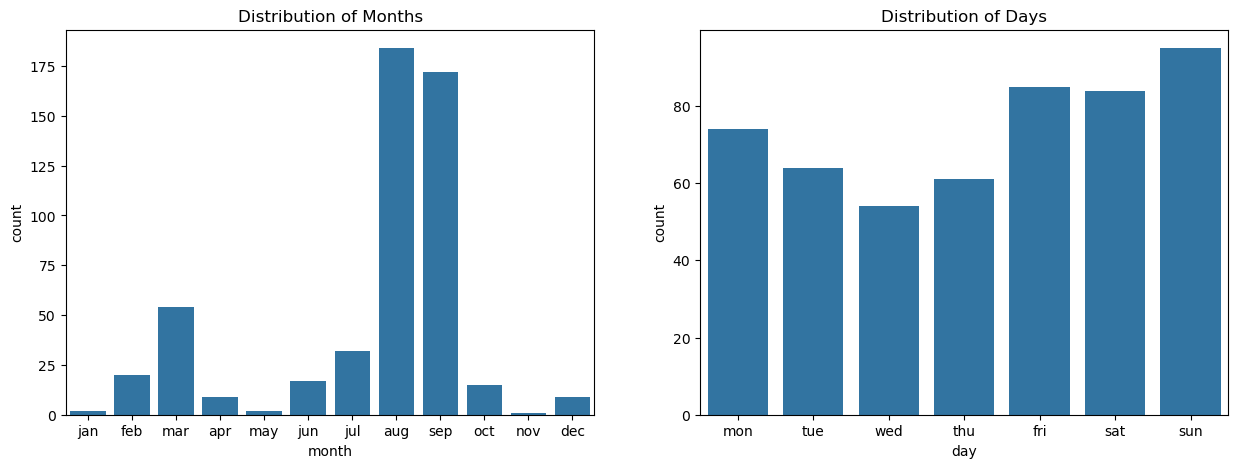

In [8]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Convert month and day columns to ordered categorical types (for plotting purposes)
fires['month'] = pd.Categorical(fires['month'], categories=month_order, ordered=True)
fires['day'] = pd.Categorical(fires['day'], categories=day_order, ordered=True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(fires, x='month')
plt.title("Distribution of Months")

plt.subplot(1,2,2)
sns.countplot(fires, x='day')
plt.title("Distribution of Days")
plt.show()

From plotting 'month' we can observe most fires happen during the months of August and September. With respect to 'day', the data is more evenly distributed, but most fires happen during the Fridays, Saturdays and Sundays.

For the **numerical variables**, some like 'FFMC' (from 18.7 to 96.2) or 'DC' (from 7.9 to 860.6) have different varying scales so they need to be normalized. We can also check the distirbuion of the numerical to look for non-normal distributions:

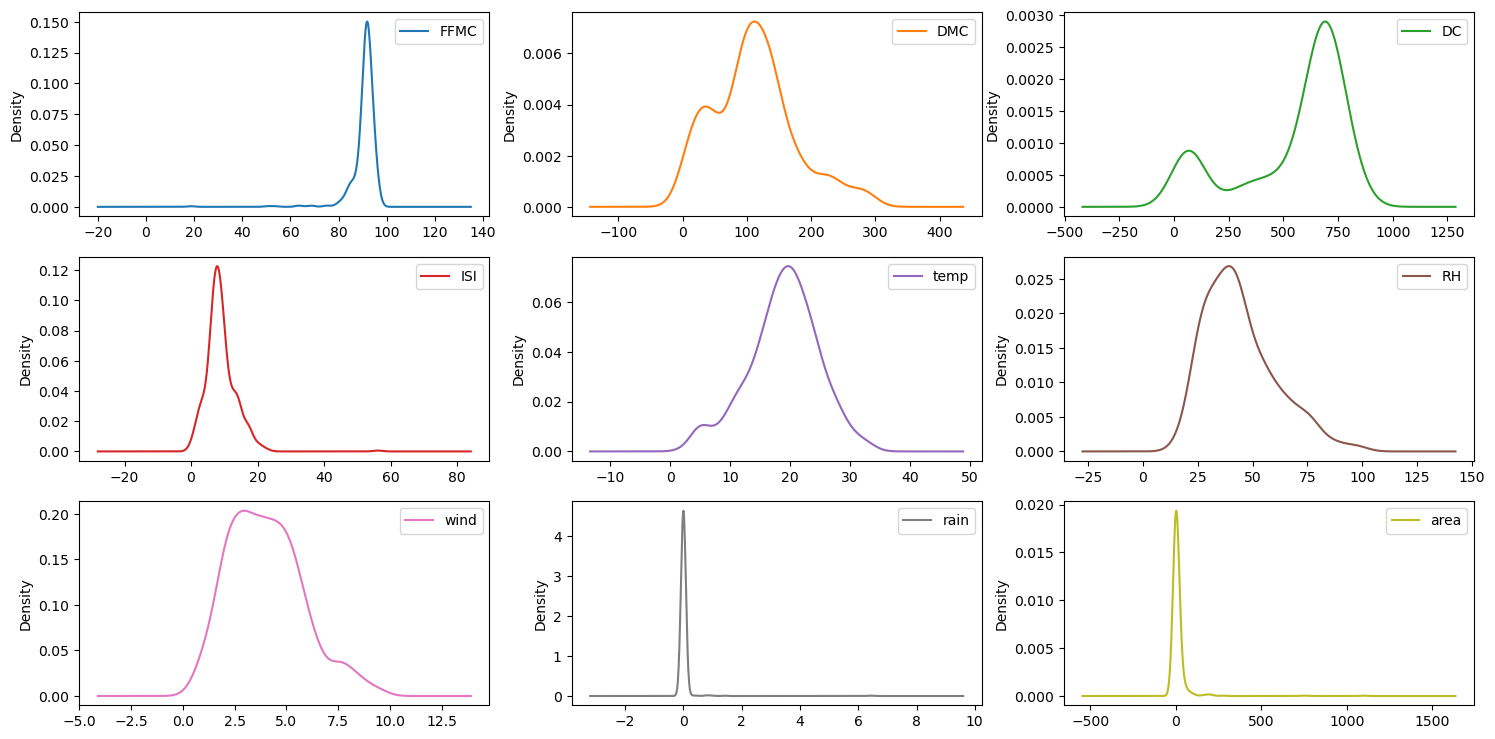

In [9]:
num_var = fires.loc[:, ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']]
num_var.plot(kind="density", subplots=True, layout=[3,3], figsize=[18,9], sharex=False, ylabel=False)
plt.show()

As we can see from the plots, 'FFMC', 'ISI', 'rain', 'RH' and 'area' are skewed, so in order to be able to use linear regression, we will need to transform and normalize our data.<br><br>

To better visualize the 'X' and 'Y' variables we can plot them in a heatmap as they represent coordinates, jointly with our dependent variable 'area'. It is worth mentioning that the variable 'area' contains many zero-value entries because burned areas smaller than (0.01 ha) 100m2 are counted as 0. 

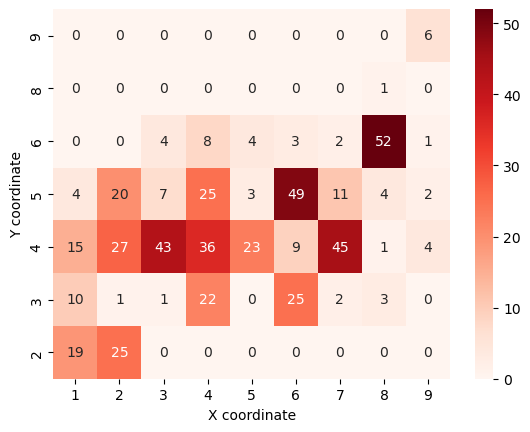

In [10]:
heatmap_data = pd.pivot_table(fires, values='area', index='Y', columns='X', aggfunc='count', fill_value=0)
hm = sns.heatmap(heatmap_data, annot=True, cmap='Reds')
hm.invert_yaxis()
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

## 2. Data preparation and normalization

### 2.1. Data transformations

In order to make the data more suitable for modelling, some transformations need to be applied.<br><br>

The log transformation is commonly used for right-skewed distributions and in this case it was used for the variables 'ISI', 'RH', 'rain' and 'area'. On the other hand, the power transformation was used for the variable 'FFMC' as it is more suitable for left-skewed distributions. 

In [11]:
fires['area_log'] = np.log1p(fires.area)  # it applies log(1+x)
fires['rh_log'] = np.log1p(fires.RH)
fires['rain_log'] = np.log1p(fires.rain)
fires['isi_log'] = np.log1p(fires.ISI)

fires['ffmc_power'] = fires.FFMC ** 12 # power transformation

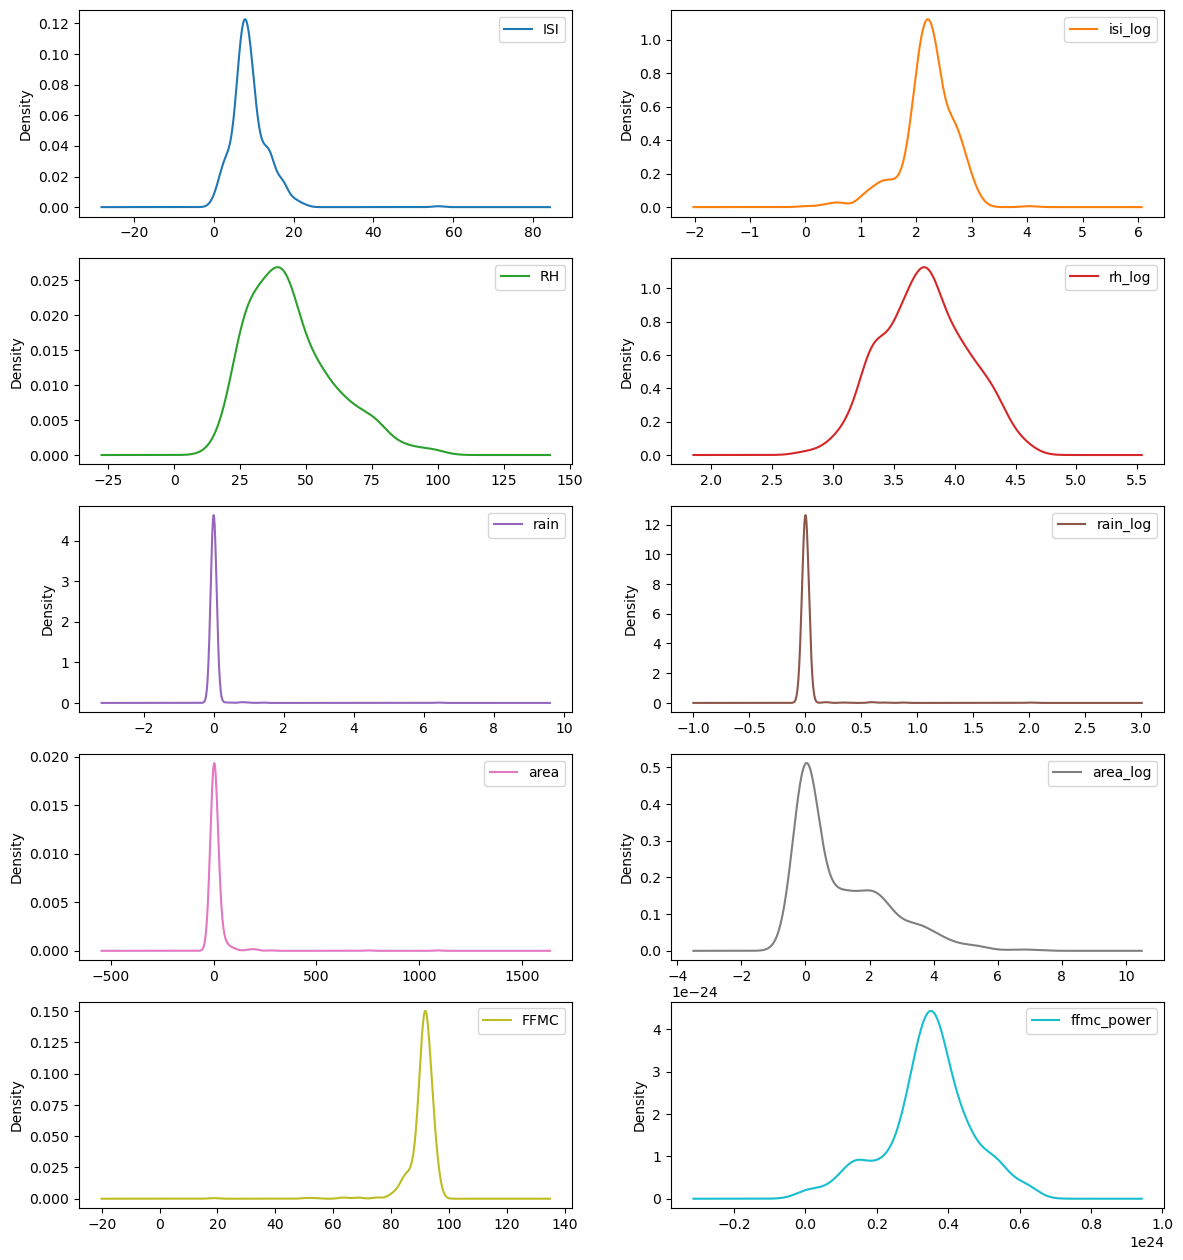

In [12]:
transf_var = fires.loc[:, ['ISI', 'isi_log', 'RH', 'rh_log', 'rain', 'rain_log', 'area', 'area_log', 'FFMC', 'ffmc_power']]
transf_var.plot(kind="density", subplots=True, layout=[7,2], figsize=[14,22], sharex=False, ylabel=False)
plt.show()

In [13]:
fires_area = fires.area #save original area values
fires = fires.drop(['ISI','RH','rain','area','FFMC'], axis=1) #keep the transformed values for the downstream analysis

One-hot encoding will be used, so no misleading assumptions of magnitude are introduced and to ensure each category is treated independently:

In [14]:
fires = pd.get_dummies(fires, columns=['month','day'], drop_first=False, dtype=int)
fires.head(5)

,X,Y,DMC,DC,temp,wind,area_log,rh_log,rain_log,isi_log,...,month_oct,month_nov,month_dec,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,day_sun
0,7,5,26.2,94.3,8.2,6.7,0.0,3.951244,0.000000,1.808289,...,0,0,0,0,0,0,0,1,0,0
1,7,4,35.4,669.1,18.0,0.9,0.0,3.526361,0.000000,2.041220,...,1,0,0,0,1,0,0,0,0,0
2,7,4,43.7,686.9,14.6,1.3,0.0,3.526361,0.000000,2.041220,...,1,0,0,0,0,0,0,0,1,0
3,8,6,33.3,77.5,8.3,4.0,0.0,4.584967,0.182322,2.302585,...,0,0,0,0,0,0,0,1,0,0
4,8,6,51.3,102.2,11.4,1.8,0.0,4.605170,0.000000,2.360854,...,0,0,0,0,0,0,0,0,0,1


### 2.2. Normalization and subsetting of the data

Normalization is done in order to scale the values so that they can be comparable. In this case, we will use min-max normalization as it preserves the shapes of the distributions.<br><br>

It is important to note that the scaling will just be done in the numerical variables ('month' and 'day' excluded).

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [16]:
# Initialize the MinMaxScaler for the X and y
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
num_var = ['X','Y', 'DMC', 'DC', 'temp', 'wind', 'rh_log', 'rain_log', 'isi_log', 'ffmc_power']

# Split the dataset
X = fires.loc[:, fires.columns != 'area_log']
y = fires.loc[:,'area_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

X_train_scaled = X_train.copy() # to apply min/max only in the numerical variables
X_test_scaled = X_test.copy()

# Fitting and transforming the numerical variables of training data
X_train_scaled[num_var] = scaler_x.fit_transform(X_train[num_var])
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) # reshape because MinMaxScaler expects 2D array

# Only transforming the numerical variables from test data!!
X_test_scaled[num_var] = scaler_x.transform(X_test[num_var])
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))


### 2.3. Check for correlations

Lastly, the Pearson correlation coefficient will be used to analyse pairwise correlations. The correlation coefficients range between -1 and 1, where positive/negative values indicate a positive/negative relationship between the variables (not to mistake with causality) and values close to 0 represent no linear correlation between them.<br>
It is also worth mentioning that the Pearson correlation coefficient is only able to measure correlation among two pairs of predictors, so we will not detect multicolinearity if any.

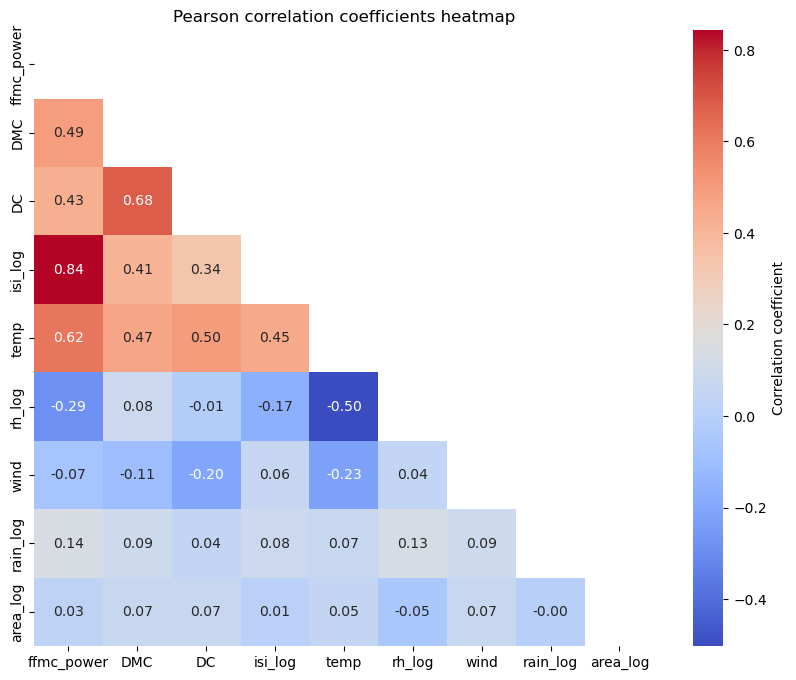

In [17]:
num_var = fires.loc[:, ['ffmc_power', 'DMC', 'DC', 'isi_log', 'temp', 'rh_log', 'wind', 'rain_log', 'area_log']]
correlation_matrix = num_var.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # upper triangular array (to show only half of the heatmap)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar_kws={'label': 'Correlation coefficient'})
plt.title('Pearson correlation coefficients heatmap')
plt.show()

The ISI and FFMC indexes appear to be the more strongly correlated predictors among all pairs. ISI (Initial Spread Index) indicates the rate fire will spreat in it's early stages and it is calculated from FFMC (Fine Fuel Moisture Code), which shows the relative ease of ignition.<br>
DC and DMC, both related to moisture content, also appear to be correlated. Area is not strongly linearly correlated to any of the predictors.

## 3. Model creation


In [18]:
from sklearn.metrics import mean_squared_error, r2_score

### 3.1. Simple linear regression

The first model trained will be a simple linear regression model. It will serve as a baseline for comparison with other more complex models.

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
# Simple linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
y_pred_linear = model.predict(X_test_scaled)

**Evaluation:**<br> 
Since we have trained our model with scaled data, in order to calculate the evaluation metrics we need to revert the scale in order to get back the original measures.

In [21]:
# Regression error Characteristic (REC) curve function from https://amirhessam88.github.io/regression-error-characteristics-curve/
from scipy.integrate import simps

def REC(y_true , y_pred):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 2.2
    Interval_Size = 0.001
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_true)):
            # Euclidean distance between y_true[j] and y_pred[j], normalized by the square root of the sum of the magnitudes of the true and predicted values.
            if np.linalg.norm(y_true[j] - y_pred[j]) / np.sqrt( np.linalg.norm(y_true[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_true))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy, Epsilon) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon, Accuracy, AUC

In [22]:
y_test_rescale = scaler_y.inverse_transform(y_test_scaled)
y_pred_rescale = scaler_y.inverse_transform(y_pred_linear)

# Residuals
residuals_linear = y_test_rescale - y_pred_rescale

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test_rescale, y_pred_rescale)
rmse_linear = math.sqrt(mse_linear)
r2_linear = r2_score(y_test_rescale, y_pred_rescale)

# Determine correct predictions
threshold = 1.1 # hectares
predictions_linear = np.abs(residuals_linear) <= threshold
percentage_linear = np.mean(predictions_linear) * 100

# REC curve using function
deviation, accuracy, AUC = REC(y_test_rescale , y_pred_rescale)

print(f"Accuracy = ", round(percentage_linear, 1), "%")
print(f'MSE (rescaled, test): {mse_linear:.3f}')
print(f'RMSE (rescaled, test): {rmse_linear:.3f}')
print(f'R² (rescaled, test): {r2_linear:.3f}')


Accuracy =  54.8 %
MSE (rescaled, test): 2.285
RMSE (rescaled, test): 1.512
R² (rescaled, test): -0.040


/tmp/ipykernel_95800/505768677.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  AUC = simps(Accuracy, Epsilon) / End_Range


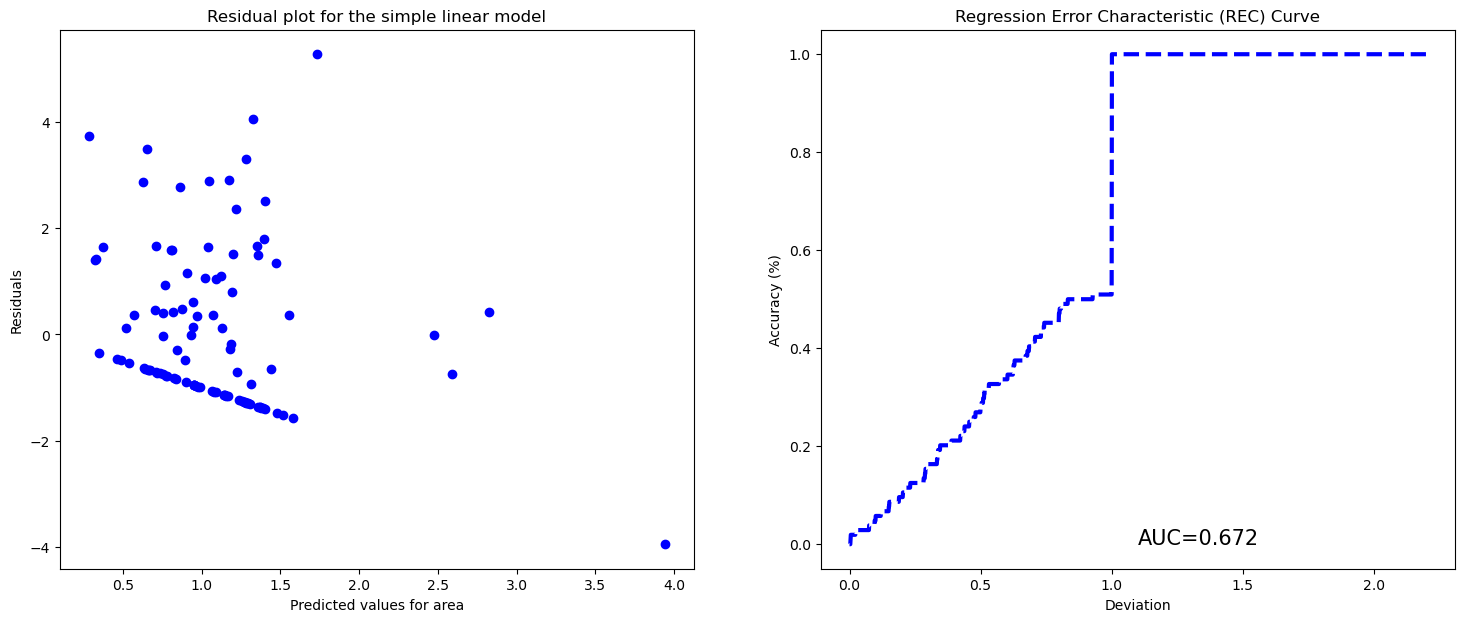

In [23]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_rescale, residuals_linear, color='blue')
plt.title('Residual plot for the simple linear model')
plt.xlabel('Predicted values for area')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.plot(deviation, accuracy, '--b', lw=3)
plt.title('Regression Error Characteristic (REC) Curve')
plt.xlabel('Deviation')
plt.ylabel('Accuracy (%)')
plt.text(1.1, 0, "AUC=%0.3f" %AUC, fontsize=15 )
plt.show()

As we can see for the evaluation, the simple linear regression model appears to perform poorly:
- The high RMSE indicates a considerable deviation from the actual values. The high MSE (average square difference between observed and predicted) also indicates poor model performance
- R² value (proportion of variance in the dependent that is predictable by the independent) indicates 0.0% of the variance is explained by the model, also a poor fit and the negative value eenotes that the model does not work better than a random guess.
- Residuals ideally would be randomly scattered around 0, however there seems to be some clustering near -1. This pattern suggests some possible overestimation of the data and another more disperse cluster around 2 could indicate underestimation of the data.
- Referring to the REC curve, the value of 0.672 for AUC indicates that the model's is just slightly better than random guessing. It indicates that 67.2% of the time, the model's predictions fall within a reasonable error tolerance compared to the actual values.

### 3.2. Ridge regression

The Ridge regression (also L2 regularization) is an extension of hte linear regression that includes a regularization term in the cost function. This regularization penalizes the size of the coefficients, reducing the variance in the model and making it more stable and less sensitive to multicolinearity.<br>
It is also usefull to mitigate overfitting, common in OLS linear regression and small datasets.<br>

In [24]:
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge

In [25]:
# Find best alpha: 
ridge_cv = RidgeCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(X_train_scaled, y_train_scaled)
alpha_opt = ridge_cv.alpha_

# Create a Kernel Ridge Regression (KRR) model:
kernelridge = KernelRidge(kernel ='rbf', alpha=alpha_opt)
kernelridge.fit(X_train_scaled, y_train_scaled)
y_pred_kridge = kernelridge.predict(X_test_scaled)

**Evaluation:**


In [26]:
y_test_rescale = scaler_y.inverse_transform(y_test_scaled)
y_pred_rescale = scaler_y.inverse_transform(y_pred_kridge)

# Residuals
residuals_kridge = y_test_rescale - y_pred_rescale

# Calculate evaluation metrics
mse_kridge = mean_squared_error(y_test_rescale, y_pred_rescale)
rmse_kridge = math.sqrt(mse_kridge)
r2_kridge = r2_score(y_test_rescale, y_pred_rescale)

# Determine correct predictions
predictions_kridge = np.abs(residuals_kridge) <= threshold
percentage_kridge = np.mean(predictions_kridge) * 100

# REC curve using function
deviation, accuracy, AUC = REC(y_test_rescale , y_pred_rescale)

print(f"Accuracy = ", round(percentage_kridge, 1), "%")
print(f'MSE (rescaled, test): {mse_kridge:.3f}')
print(f'RMSE (rescaled, test): {rmse_kridge:.3f}')
print(f'R² (rescaled, test): {r2_kridge:.3f}')

Accuracy =  59.6 %
MSE (rescaled, test): 2.189
RMSE (rescaled, test): 1.479
R² (rescaled, test): 0.004


/tmp/ipykernel_95800/505768677.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  AUC = simps(Accuracy, Epsilon) / End_Range


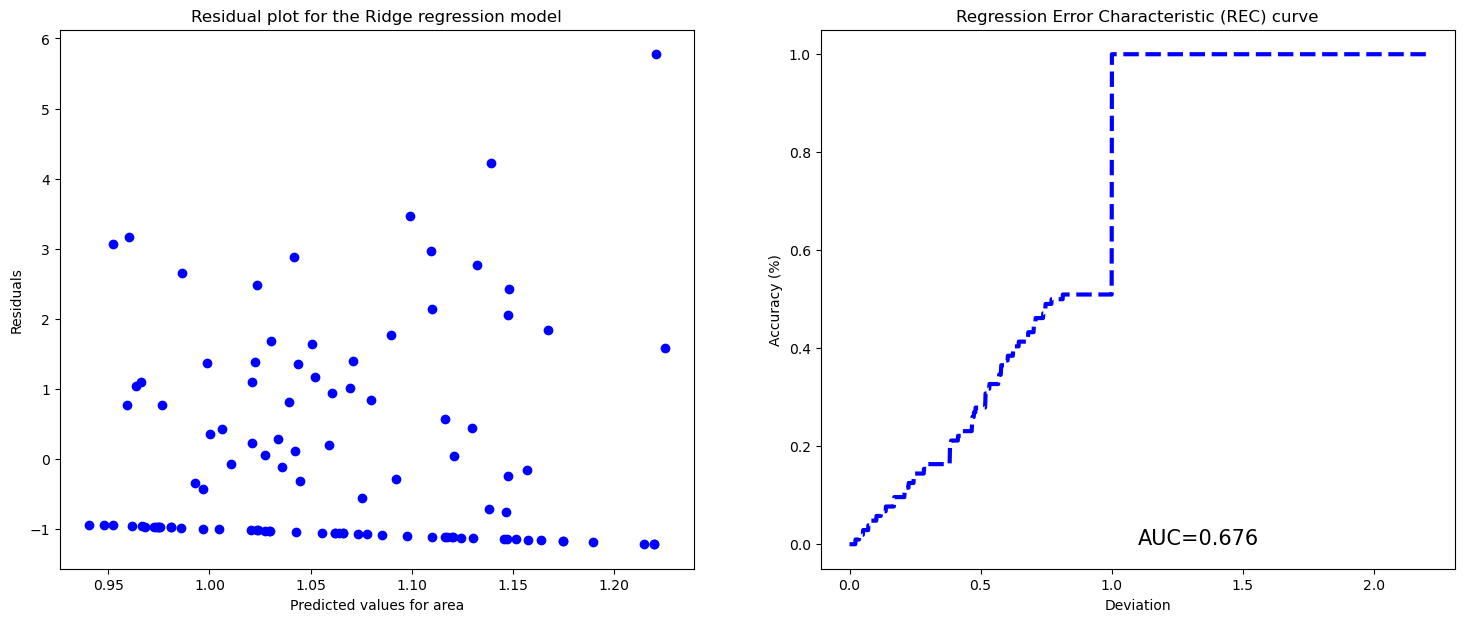

In [27]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_rescale, residuals_kridge, color='blue')
plt.title('Residual plot for the Ridge regression model')
plt.xlabel('Predicted values for area')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.plot(deviation, accuracy, '--b', lw=3)
plt.title('Regression Error Characteristic (REC) curve')
plt.xlabel('Deviation')
plt.ylabel('Accuracy (%)')
plt.text(1.1, 0, "AUC=%0.3f" %AUC, fontsize=15 )
plt.show()

As we can see from the results, there is no performance improvement in using a Ridge regression model for this data. However the residuals seem more randomly scattered around 0, which indicates that the Ridge regression did help improving the results, although the clustering around -1 it is stil present.
This could indicate that the relationship between predictors and target is more complex and non-linear.

### 3.3. Random forest

As a more complex model, a Random Forest regressor will be used as it can capture non-linear relationships and will help us have a look at the feature importance.<br>
The data without scaling was used as this does not affect the results from random forest models.


In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_train_pred = rfr.predict(X_train) #for RMSE
y_pred = rfr.predict(X_test)

**Evaluation:**


In [30]:
# Calculate MSE and RMSE for training and test sets
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = math.sqrt(mse_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = math.sqrt(mse_train)

# Calculate R² score on the test set
r2_forest = r2_score(y_test, y_pred)

print(f'MSE (train) = {mse_train:.3f}; MSE (test) = {mse_test:.3f}')
print(f'RMSE (train) = {rmse_train:.3f}; RMSE (test) = {rmse_test:.3f}')
print(f'R² = {r2_forest:.3f}')


MSE (train) = 0.316; MSE (test) = 2.339
RMSE (train) = 0.562; RMSE (test) = 1.529
R² = -0.064


In [31]:
# Residuals
residuals_forest_test = y_test.values.reshape(-1) - y_pred.reshape(-1)
residuals_forest_train = y_train.values.reshape(-1) - y_train_pred.reshape(-1)

# Determine correct predictions
predictions_forest = np.abs(residuals_forest_test) <= threshold
percentage_forest = np.mean(predictions_forest) * 100

We can more easily compare the results from three models used so far in the following table:

In [32]:
metrics = {
    'Model': ['Linear model', 'Ridge regression', 'Random forest'],
    'MSE': [mse_linear, mse_kridge, mse_test],
    'RMSE': [rmse_linear, rmse_kridge, rmse_test],
    'R²': [r2_linear, r2_kridge, r2_forest],
    'Accuracy (%)': [percentage_linear, percentage_kridge, percentage_forest]
}
metrics_df = pd.DataFrame(metrics)
metrics_df.round(2)

,Model,MSE,RMSE,R²,Accuracy (%)
0,Linear model,2.28,1.51,-0.04,54.81
1,Ridge regression,2.19,1.48,0.00,59.62
2,Random forest,2.34,1.53,-0.06,51.92


As shown by the results, the three models perform quite poorly.<br>
The **linear regression model** has the highest error among the three of them and the RMSE indicates that, on average, the predictions are off by about 1.51 units from the actual value. The negative R² score, suggests it is performing worse than a model that simply predicts the mean of the area (target variable).<br>

The **Ridge regression model** has a slightly better performance than the linear regression model in therms of error and accuracy but it also does not explain any variance (R² = 0.00).<br>

Lastly, the **random forest regressor** also does not provide any improvement. As we can see from the results from the MSE and RMSE from the training and testing data there are big differences between the training and testing values, which likely indicates overfitting. I will perform some other checks and hyperparameter tunning to evaluate if the performance can be improved.

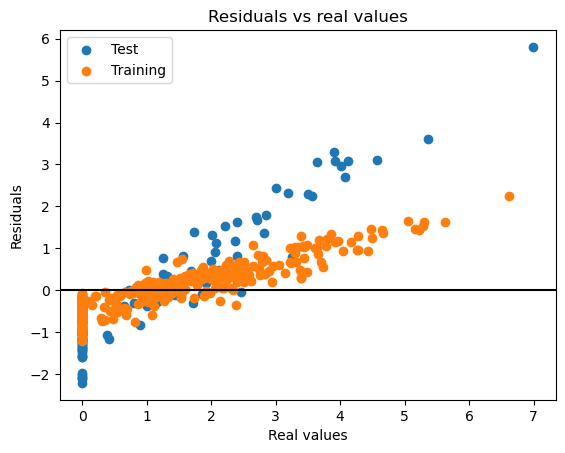

In [33]:
plt.scatter(y_test, residuals_forest_test)
plt.scatter(y_train, residuals_forest_train)
plt.axhline(y=0.0, color='black', linestyle='-')
plt.title("Residuals vs real values")
plt.xlabel("Real values")
plt.ylabel("Residuals")
plt.legend(['Test', 'Training'])
plt.show()

When looking at the residuals plot from the training and testing data we can see there are high discrepancies between the real data and the predicted ones, specially for larger values of y (area burned). It seems like the model might be **overestimating on small values and underestimating on the larger values**, which indicates **systematic bias**.<br><br>

We will have a look at which features are more important for predictions:

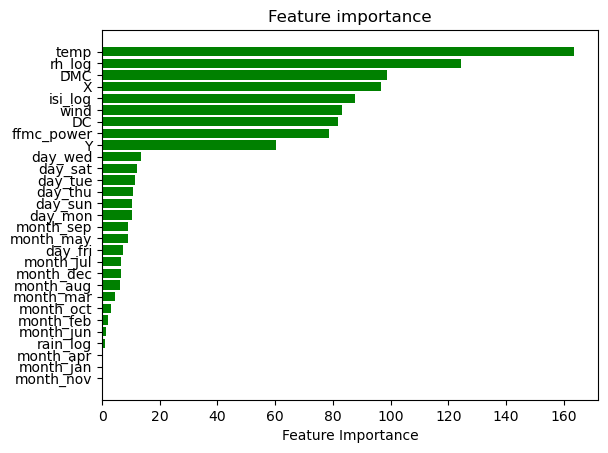

In [34]:
imps_df = pd.DataFrame({'names': X_test.columns, 'values': (rfr.feature_importances_)*1000})
imps_df = imps_df.sort_values('values')
plt.barh(imps_df['names'], imps_df['values'], color='green')
plt.title('Feature importance')
plt.xlabel('Feature Importance')
plt.show()

'temp' (Temperature) and 'RH' (Relative Humidity) have the largest predictive power followed by the 'DMC' index and the 'X' coordinate. The 'day' and 'month' features have little importance.

In [35]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

Parameter hypertuning will be performed with cross-validation:

In [36]:
param_grid = {
    'max_depth': [None, 1, 2, 5, 10],
    'max_features' : [1, 5, 10],
    'n_estimators': [10, 50, 100, 150]}

# GridSearch with Cross Validation:
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state = 42), 
                           param_grid = param_grid, 
                           cv = KFold(n_splits=5, shuffle=True, random_state = 42))
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: ", best_params)
print(f"Best score:", grid_search.best_score_)


In [ ]:
# Implement the hyperparamether tuning:
rfr_tunning = RandomForestRegressor(random_state=42, **best_params)
rfr_tunning.fit(X_train, y_train)
y_pred_tunning = rfr_tunning.predict(X_test)
y_train_pred_tunnig = rfr_tunning.predict(X_train)

In [ ]:
# Evaluation of the model: 
score_grid = cross_val_score(rfr_tunning, X_train, y_train,
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Evaluation metrics:
mse_tuned_test = mean_squared_error(y_test, y_pred_tunning)
rmse_tuned_test = math.sqrt(mse_tuned_test)

mse_tuned_train = mean_squared_error(y_train, y_train_pred_tunnig)
rmse_tuned_train = math.sqrt(mse_tuned_train)

r2_tuned = r2_score(y_test, y_pred_tunning)
residuals_tuned_test = y_test - y_pred_tunning
residuals_tuned_train = y_train - y_train_pred_tunnig

# Determine correct predictions
predictions_tuned = np.abs(residuals_tuned_test) <= threshold
percentage_tuned = np.mean(predictions_tuned) * 100

print(f'MSE (train, tuned) = {mse_tuned_train:.3f}; MSE (test, tuned) = {mse_tuned_test:.3f}')
print(f'RMSE (train, tuned) = {rmse_tuned_train:.3f}; RMSE (test, tuned) = {rmse_tuned_test:.3f}')
print(f'R² (tuned) = {r2_tuned:.3f}')


MSE (train, tuned) = 1.870; MSE (test, tuned) = 2.194
RMSE (train, tuned) = 1.367; RMSE (test, tuned) = 1.481
R² (tuned) = 0.002


The reduction in the gap beteween the testing and training values suggests that the tuning might have reduced the overfitting (generalizes better to unseen data). However the testing values are still higher than the trainig indicating there is still some overfitting.

If we compare again the test residuals from the base and tuned random forest models:

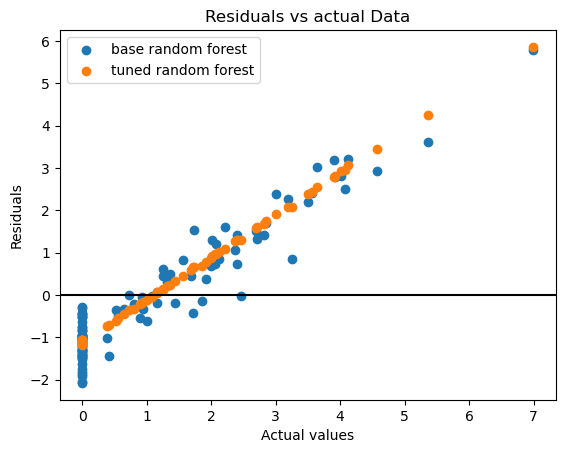

In [ ]:
plt.scatter(y_test, residuals_forest_test)
plt.scatter(y_test, residuals_tuned_test)
plt.axhline(y=0.0, color='black', linestyle='-')
plt.title("Residuals vs actual Data")
plt.xlabel("Actual values")
plt.ylabel("Residuals")
plt.legend(["base random forest", "tuned random forest"])
plt.show()

It is clear that both have difficulties predicting higher target values accurately and that the tunig did not improve the model's performance (although the tuned forest's residuals seem to be closer to 0).<br><br>

If we have a look at the results from all the models together:

In [ ]:
tuned_forest = pd.DataFrame({
    'Model': 'Tuned random forest',
    'MSE': [mse_tuned_test],
    'RMSE': [rmse_tuned_test],
    'R²': [r2_tuned],
    'Accuracy (%)': [percentage_tuned]
})
metrics2 = pd.concat([metrics_df, tuned_forest], ignore_index=True).round(3)
metrics2

,Model,MSE,RMSE,R²,Accuracy (%)
0,Linear model,2.285,1.512,-0.040,54.808
1,Ridge regression,2.189,1.479,0.004,59.615
2,Random forest,2.237,1.496,-0.018,54.808
3,Tuned random forest,2.194,1.481,0.002,46.154


The **tuned random forest** has relatively high values for MSE and RMSE values like all of the other models implemented. The model it's still performing poorly, even after the tuning, and explains near-zero of the variance of the data (low R²).<br><br>

It can be said, that from the methods evaluated here, the **Ridge regression model** one performing the best, although it still fails at explaining any variance in the data and it is still far to be considered a good model for this dataset.

## 4. Conclusion

None of the 4 models tried were able to correctly predict the area burnt by forest fires in a significative manner using the provided dataset.<br>
In order to understand the underlying structure of the data it might be required to use more advanced modelling techniques. It would also be interesting to implement a model using just one or a subset of the features. Nevertheless it might also be a posibility that the provided data is not enough and that more information is required in order to give better predictions about this problem.<br>
Some other measures that might be of intestest could be types of vegetation, possible human involvement in the start of the fire or 'Land surface termperature' (LST). It might also be relevant to indicate the exact area burned instead of measuring it as 0 whenever is below a threshold.